#Prepocessing

In [ ]:
import pandas as pd

# Membaca data
df = pd.read_csv("datatime.csv")

# Mengecek missing value per kolom
missing_per_column = df.isnull().sum()
print(missing_per_column)


Country            0
Code             132
Year               0
Stroke_Deaths      0
dtype: int64


#Menghapus data yang bukan negara dan menghapus kolom yang tidak digunakan

In [2]:
# 1. Hapus baris entitas agregat (bukan negara)
REMOVE = [
    "World", "Asia", "Africa", "Europe", "European Union",
    "North America", "South America", "Latin America and Caribbean",
    "Oceania"
]

df = df[~df['Country'].isin(REMOVE)]

# 2. Hapus duplikasi jika ada
df = df.drop_duplicates()

# 3. Tangani missing value dengan interpolasi per negara
df['Stroke_Deaths'] = df.groupby('Country')['Stroke_Deaths'] \
                        .transform(lambda x: x.interpolate(method='linear'))

# Jika masih ada NA → isi median negara
df['Stroke_Deaths'] = df.groupby('Country')['Stroke_Deaths'] \
                        .transform(lambda x: x.fillna(x.median()))

# 4. Ubah tipe data agar rapi
df['Year'] = df['Year'].astype(int)
df['Stroke_Deaths'] = df['Stroke_Deaths'].astype(float)

# 5. Sort berdasarkan negara dan tahun
df = df.sort_values(by=['Country', 'Year']).reset_index(drop=True)

# Menghapus kolom 'nama_kolom'
df = df.drop(columns=['Code'])

# Menyimpan hasil ke file CSV baru
df.to_csv("datafix.csv", index=False)

# Tampilkan hasil akhir preprocessing dasar
df.head(10)


,Country,Year,Stroke_Deaths
0,Afghanistan,2000,14641.85
1,Afghanistan,2001,14892.41
2,Afghanistan,2002,15578.43
3,Afghanistan,2003,16700.15
4,Afghanistan,2004,17119.86
5,Afghanistan,2005,17303.96
6,Afghanistan,2006,17496.20
7,Afghanistan,2007,17366.04
8,Afghanistan,2008,17019.65
9,Afghanistan,2009,16752.88


#Modelling

In [3]:
!pip install "u8darts[torch]" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.6 MB/s eta 0:00:00


In [4]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


##konversi data menjadi time series

In [3]:
import pandas as pd

from darts import TimeSeries
from darts.models import NBEATSModel
import torch

# ganti path jika perlu
df = pd.read_csv("datafix.csv")

# pastikan kolomnya apa saja
print(df.columns)

# sort biar rapi
df = df.sort_values(["Country", "Year"])

# ubah Year jadi datetime (misal pakai 1 Januari tiap tahun)
df["Year"] = pd.to_datetime(df["Year"].astype(str), format="%Y")

print(df.head())


Index(['Country', 'Year', 'Stroke_Deaths'], dtype='object')
       Country       Year  Stroke_Deaths
0  Afghanistan 2000-01-01       14641.85
1  Afghanistan 2001-01-01       14892.41
2  Afghanistan 2002-01-01       15578.43
3  Afghanistan 2003-01-01       16700.15
4  Afghanistan 2004-01-01       17119.86


##pisahkan data pernegara

In [4]:
# dictionary: {nama_negara: dataframe_negara}
country_dfs = {
    country: sub_df[["Year", "Stroke_Deaths"]].reset_index(drop=True)
    for country, sub_df in df.groupby("Country")
}

# contoh cek 1 negara
print(list(country_dfs.keys())[:5])  # 5 negara pertama
print(country_dfs["Afghanistan"].head())


['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola']
        Year  Stroke_Deaths
0 2000-01-01       14641.85
1 2001-01-01       14892.41
2 2002-01-01       15578.43
3 2003-01-01       16700.15
4 2004-01-01       17119.86


##ubah ke timeseries pernegara

In [5]:
from typing import Dict

# dictionary: {nama_negara: TimeSeries}
series_by_country: Dict[str, TimeSeries] = {}

for country, cdf in country_dfs.items():
    ts = TimeSeries.from_dataframe(
        cdf,
        time_col="Year",
        value_cols="Stroke_Deaths"  # hanya 1 variabel yang diprediksi
    )
    series_by_country[country] = ts

# cek 1 contoh
print(series_by_country["Afghanistan"])


            Stroke_Deaths
Year                     
2000-01-01       14641.85
2001-01-01       14892.41
2002-01-01       15578.43
2003-01-01       16700.15
2004-01-01       17119.86
...                   ...
2017-01-01       19422.18
2018-01-01       19827.60
2019-01-01       20464.81
2020-01-01       21660.82
2021-01-01       20306.80

shape: (22, 1, 1), freq: YS-JAN, size: 176.00 B


##Latih model n-beats

In [7]:
from darts.models import NBEATSModel

# panjang window (disesuaikan dengan data yang pendek)
input_chunk_length = 2      # lihat 2 titik ke belakang
output_chunk_length = 1     # prediksi 1 langkah per window
min_required_len = input_chunk_length + output_chunk_length  # = 3

print("Minimal panjang untuk train:", min_required_len)


Minimal panjang untuk train: 3


In [8]:
# setting model (disesuaikan dengan panjang data yang pendek)
input_chunk_length = 2      # lihat 2 titik ke belakang
output_chunk_length = 1     # prediksi 1 langkah per window
min_required_len = input_chunk_length + output_chunk_length  # = 3

train_series = []

for country, ts in series_by_country.items():
    L = len(ts)
    if L < min_required_len:
        print(f"{country}: data terlalu pendek (len={L}), SKIP dari training.")
        continue

    train_series.append(ts)

print("Banyak negara yang dipakai training:", len(train_series))

# MODEL GLOBAL
global_model = NBEATSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    n_epochs=5,        # boleh dinaikkan kalau mau lebih serius
    batch_size=16,
    random_state=42,
)

print("Mulai training model global N-BEATS...")
global_model.fit(series=train_series, verbose=True)
print("Selesai training model global.")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Banyak negara yang dipakai training: 194
Mulai training model global N-BEATS...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.0 M  | train
-------------------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.088    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Selesai training model global.


##Evaluasi model n-beats pernegara

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from darts.metrics import mape, mae, rmse

def ts_to_df(ts):
    """Konversi Darts TimeSeries ke pandas DataFrame (versi baru)."""
    if hasattr(ts, "to_dataframe"):
        df = ts.to_dataframe().reset_index()
    else:
        raise AttributeError("TimeSeries tidak punya to_dataframe().")

    cols = list(df.columns)
    cols[0] = "Date"   # kolom pertama = waktu
    df.columns = cols
    return df


In [20]:
# === EVALUASI IN-SAMPLE MODEL GLOBAL N-BEATS ===

min_required_len = input_chunk_length + output_chunk_length  # sama seperti saat training

eval_rows = []

for country, ts in series_by_country.items():
    L = len(ts)

    # pastikan cukup panjang
    if L < min_required_len + 1:
        print(f"{country}: data terlalu pendek untuk evaluasi (len={L}), skip.")
        continue

    # historical_forecasts: model pura-pura mem-forecast ke belakang di data yang sama
    backtest = global_model.historical_forecasts(
        ts,
        start=0.5,               # mulai dari 50% panjang data
        forecast_horizon=1,      # prediksi 1 langkah ke depan tiap step
        stride=1,
        retrain=False,           # pakai model yang sudah dilatih
        last_points_only=True,   # -> satu titik per forecast, lebih simpel
        verbose=False,
    )

    # beberapa versi Darts bisa balikin list, jadi kita amankan di sini
    from darts import TimeSeries
    if isinstance(backtest, list):
        if len(backtest) == 0:
            print(f"{country}: historical_forecasts mengembalikan list kosong, skip.")
            continue
        backtest = backtest[0]   # ambil TimeSeries pertama

    # jaga-jaga: kalau masih bukan TimeSeries, skip
    if not isinstance(backtest, TimeSeries):
        print(f"{country}: backtest bukan TimeSeries, skip.")
        continue

    # samakan irisan waktu antara aktual & forecast
    actual = ts.slice_intersect(backtest)
    backtest = backtest.slice_intersect(actual)

    # kalau untuk alasan tertentu tidak ada overlap, skip
    if len(actual) == 0 or len(backtest) == 0:
        print(f"{country}: tidak ada overlap waktu antara aktual & backtest, skip.")
        continue

    # hitung metrik
    mape_val = mape(actual, backtest)
    mae_val  = mae(actual, backtest)
    rmse_val = rmse(actual, backtest)

    eval_rows.append({
        "Country": country,
        "MAPE": mape_val,
        "MAE": mae_val,
        "RMSE": rmse_val,
    })

eval_df = pd.DataFrame(eval_rows).sort_values("MAPE").reset_index(drop=True)

print("Hasil evaluasi in-sample (semakin kecil semakin bagus):")
print(eval_df.head(20))   # 20 negara dengan MAPE terbaik


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_ze

Hasil evaluasi in-sample (semakin kecil semakin bagus):
                         Country      MAPE           MAE          RMSE
0                          Ghana  0.658477    143.101232    232.963263
1                        Eritrea  0.794677     22.397191     28.725187
2                        Vanuatu  0.818619      2.216071      3.001452
3                           Togo  0.848327     45.024369     67.301966
4                           Fiji  0.849291      5.713019     11.128452
5                       Pakistan  0.854259    955.046018   1711.222971
6                          Samoa  0.928743      1.491251      1.879217
7                          China  0.999539  23132.955725  27534.038008
8                         Tuvalu  1.143064      0.159824      0.205265
9                          Benin  1.149737     79.023574    111.442470
10                        Guinea  1.160024     92.529971    155.303325
11                       Comoros  1.200713      5.429949      8.589588
12  Democratic Republ

In [21]:
print(eval_df)


                 Country       MAPE         MAE         RMSE
0                  Ghana   0.658477  143.101232   232.963263
1                Eritrea   0.794677   22.397191    28.725187
2                Vanuatu   0.818619    2.216071     3.001452
3                   Togo   0.848327   45.024369    67.301966
4                   Fiji   0.849291    5.713019    11.128452
..                   ...        ...         ...          ...
189              Georgia   9.016790  926.344402  1127.228712
190            Nicaragua   9.040124   86.875106   127.118205
191              Estonia  10.938335  115.079065   141.460027
192  Antigua and Barbuda  11.822783    6.260131     9.401223
193              Albania  12.562035  919.627230  1530.352488

[194 rows x 4 columns]


##Forecasting dengan n-beats

In [25]:
min_required_len = input_chunk_length + output_chunk_length

def forecast_dan_plot_negara(country_name: str, n_years: int = 5):
    # cari negara secara case-insensitive
    country_name_norm = country_name.strip().lower()
    candidates = [c for c in series_by_country.keys() if c.lower() == country_name_norm]

    if not candidates:
        raise ValueError(f"Negara '{country_name}' tidak ditemukan di series_by_country.")

    country_key = candidates[0]
    ts = series_by_country[country_key]

    if len(ts) < min_required_len:
        raise ValueError(
            f"Data untuk {country_key} terlalu pendek (len={len(ts)}). "
            f"Butuh minimal {min_required_len} titik."
        )

    # ====== FORECAST n_years KE DEPAN ======
    fc = global_model.predict(
        n=n_years,
        series=ts
    )

    # ubah ke DataFrame
    hist_df = ts_to_df(ts)
    fc_df   = ts_to_df(fc)

    # rename kolom value
    hist_df.columns = ["Year", "Stroke_Deaths_Actual"]
    fc_df.columns   = ["Year", "Stroke_Deaths_Forecast"]

    # tampilkan tabel prediksi
    print(f"Prediksi {n_years} tahun ke depan untuk {country_key}:")
    print(fc_df)

    # ====== PLOT MIRIP GAMBAR YANG KAMU KIRIM ======
    plt.figure(figsize=(10,5))

    # garis historis (biru, default)
    plt.plot(
        hist_df["Year"],
        hist_df["Stroke_Deaths_Actual"],
        marker="o",
        label="Historical"
    )

    # garis forecast (oranye, default kedua, putus-putus)
    plt.plot(
        fc_df["Year"],
        fc_df["Stroke_Deaths_Forecast"],
        marker="o",
        linestyle="--",
        label=f"Forecast ({n_years} years)"
    )

    plt.title(f"Stroke Deaths per Year — {country_key}")
    plt.xlabel("Year")
    plt.ylabel("Stroke Deaths")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return country_key, fc_df


Masukkan nama negara: albania


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: |          | 0/? [00:00<?, ?it/s]

Prediksi 5 tahun ke depan untuk Albania:
        Year  Stroke_Deaths_Forecast
0 2022-01-01             7381.531721
1 2023-01-01             7481.514748
2 2024-01-01             7580.910369
3 2025-01-01             7681.612910
4 2026-01-01             7783.656653


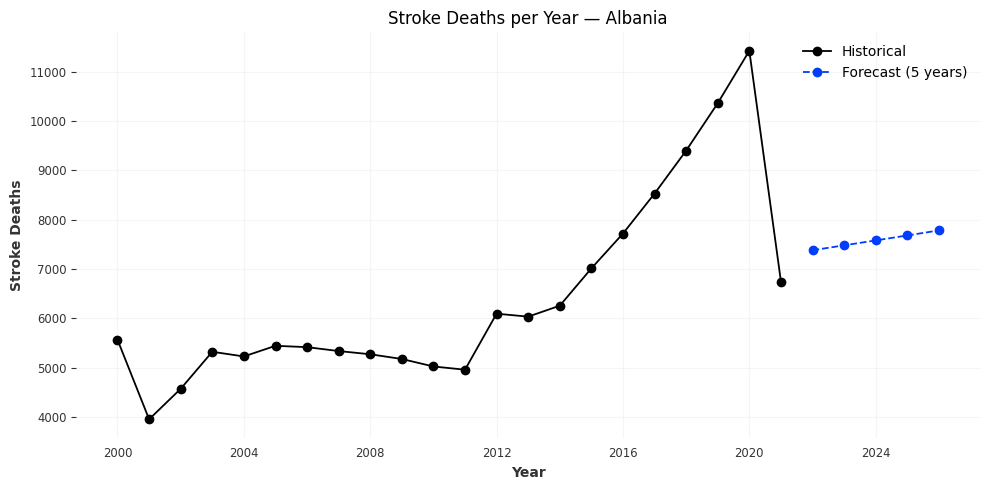

In [27]:
nama_negara = input("Masukkan nama negara: ")
country_key, pred_df = forecast_dan_plot_negara(nama_negara, n_years=5)
